In [38]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch import nn
from tqdm.auto import tqdm
from pathlib import Path
import cv2
import os


In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:{device}")

Using device:cuda


In [4]:
weights=torchvision.models.VGG19_Weights.DEFAULT
model=torchvision.models.vgg19(weights=weights)

In [5]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
class NeuralStyleTransferModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=model.features[:30]
        self.features=[0,5,10,19,28]
        for layer_no,layer in enumerate(self.model):
            if layer_no == 4 or layer_no == 9 or layer_no == 18 or layer_no ==27:
                self.model[layer_no]=nn.AvgPool2d(kernel_size=2,stride=2,padding=0,ceil_mode=False)
                
    def forward(self,x:torch.Tensor):
        styles=[]
        for layer_no,layer in enumerate(self.model):
            x=layer(x)
            if layer_no in self.features:
                styles.append(x)    
        return styles
        
        

In [7]:
torch.manual_seed(42)
nstmodel=NeuralStyleTransferModel().to(device)
for param in nstmodel.parameters():
    param.requires_grad=False 
print(f"Model is running on {next(nstmodel.parameters()).device}")


Model is running on cuda:0


In [8]:
img_transform=transforms.Compose([
     transforms.Resize(size=(224,224)),
     transforms.ToTensor()
     
])

In [9]:
def load_and_preprocess_image(image_path:str):
    img=Image.open(image_path)
    img=img_transform(img)
    img=img.unsqueeze(dim=0).to(device)
    return img
   

In [10]:
def compute_gram_matrix(mat:torch.Tensor):
    batch_dim,channels,height,width=mat.shape
    gram_mat=torch.matmul(mat.view(channels,height*width),mat.view(channels,height*width).T)
    return gram_mat

In [11]:
x=torch.randn(size=(1,3,64,64))
compute_gram_matrix(x)

tensor([[4063.3452,  -70.4251,  -47.1988],
        [ -70.4251, 4134.1982,   -5.9277],
        [ -47.1988,   -5.9277, 4109.4116]])

In [12]:
def styletransfer(epochs:int,alpha:float,beta:float,style_image_path:str,content_image_path:str,model:torch.nn.Module,w:float,device):
    style_img=load_and_preprocess_image(style_image_path).to(device)
    content_img=load_and_preprocess_image(content_image_path).to(device)
    target_img=content_img.clone().requires_grad_(True).to(device)
    optimizer=torch.optim.Adam(params=[target_img],lr=0.01)
   
    for epoch in tqdm(range(epochs)):
        model.eval()
        with torch.inference_mode():
            style_features=model(style_img)
            content_features=model(content_img)
    
        model.train()    
        target_features=model(target_img)
        style_loss,content_loss =0,0
        content_loss = 0.5 * torch.mean((target_features[-1] - content_features[-1])**2)

        for style_layer,target_layer in zip(style_features,target_features):
            _,channels,height,width=target_layer.shape
            style_gram=compute_gram_matrix(style_layer)
            target_gram=compute_gram_matrix(target_layer)
            style_loss += w* torch.mean((style_gram - target_gram)**2)/(4*((channels)**2)*(width*height))
        total_loss = alpha * content_loss + beta * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        if epoch % 10 ==0:
            print(f"Epoch:{epoch} | Train_loss:{total_loss.item()} | Content_loss:{content_loss :.4f} | Style_loss:{style_loss:.4f}")

    target_img=target_img.cpu().detach().squeeze(dim=0).permute(1,2,0).numpy()
    target_img = np.clip(target_img, 0, 1) 
    return target_img
        
    

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS=50
BETA=80000
ALPHA=0.8
W=0.2

styled_img=styletransfer(epochs=NUM_EPOCHS,alpha=ALPHA,beta=BETA,style_image_path='style-images/style-1.jpeg',content_image_path='content-images/content-3.jpg',model=nstmodel,w=W,device=device)

 10%|████████▎                                                                          | 5/50 [00:01<00:08,  5.28it/s]

Epoch:0 | Train_loss:51.517494201660156 | Content_loss:0.0000 | Style_loss:0.0006


 30%|████████████████████████▌                                                         | 15/50 [00:02<00:03,  9.80it/s]

Epoch:10 | Train_loss:10.927314758300781 | Content_loss:0.0148 | Style_loss:0.0001


 50%|█████████████████████████████████████████                                         | 25/50 [00:03<00:02, 11.49it/s]

Epoch:20 | Train_loss:3.8727972507476807 | Content_loss:0.0144 | Style_loss:0.0000


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:04<00:01, 11.75it/s]

Epoch:30 | Train_loss:1.993099331855774 | Content_loss:0.0152 | Style_loss:0.0000


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:05<00:00, 11.87it/s]

Epoch:40 | Train_loss:1.3922995328903198 | Content_loss:0.0160 | Style_loss:0.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.09it/s]


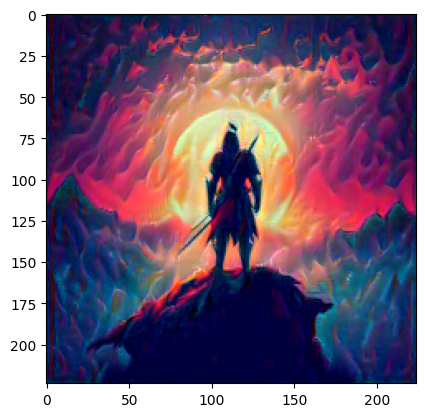

In [14]:
plt.imshow(styled_img)

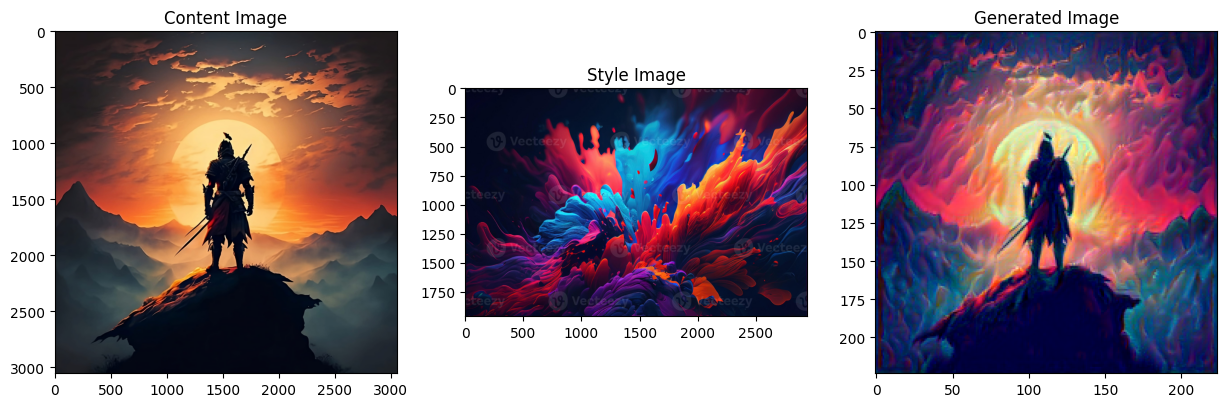

In [15]:
plt.figure(figsize=(15,7))
nrows,ncols=1,3
img1=Image.open('style-images/style-1.jpeg')
img2=Image.open('content-images/content-3.jpg')
i=1
plt.subplot(nrows,ncols,i)
i+=1
plt.imshow(img2)
plt.title("Content Image")
plt.subplot(nrows,ncols,i)
i+=1
plt.imshow(img1)
plt.title("Style Image")
plt.subplot(nrows,ncols,i)
plt.title("Generated Image")
plt.imshow(styled_img)

In [16]:
def generateImage(style_image_path:str,content_image_path:str):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    NUM_EPOCHS=100
    BETA=80000
    
    ALPHA=0.8
    W=0.2
    
    styled_img=styletransfer(epochs=NUM_EPOCHS,alpha=ALPHA,beta=BETA,style_image_path=style_image_path,content_image_path=content_image_path,model=nstmodel,w=W,device=device)
    plt.figure(figsize=(15,7))
    nrows,ncols=1,3
    img1=Image.open(content_image_path)
    img2=Image.open(style_image_path)
    i=1
    plt.subplot(nrows,ncols,i)
    i+=1
    plt.imshow(img1)
    plt.title("Content Image")
    plt.subplot(nrows,ncols,i)
    i+=1
    plt.imshow(img2)
    plt.title("Style Image")
    plt.subplot(nrows,ncols,i)
    plt.title("Generated Image")
    plt.imshow(styled_img)

    j=np.random.randint(0,100000)
    styled_img_pil = Image.fromarray((styled_img * 255).astype(np.uint8))
    output_folder = Path("generated-images")
    output_folder.mkdir(exist_ok=True,parents=True)  
    output_path = output_folder / f"image_{j}.png"
    styled_img_pil.save(output_path)
    print(f"Generated image saved to {output_path}")
    j += 1

  5%|████                                                                              | 5/100 [00:00<00:07, 12.19it/s]

Epoch:0 | Train_loss:20.82744789123535 | Content_loss:0.0000 | Style_loss:0.0003


 15%|████████████▏                                                                    | 15/100 [00:01<00:07, 11.91it/s]

Epoch:10 | Train_loss:5.7492804527282715 | Content_loss:0.0191 | Style_loss:0.0001


 25%|████████████████████▎                                                            | 25/100 [00:02<00:06, 12.08it/s]

Epoch:20 | Train_loss:0.7268508672714233 | Content_loss:0.0170 | Style_loss:0.0000


 35%|████████████████████████████▎                                                    | 35/100 [00:03<00:05, 11.86it/s]

Epoch:30 | Train_loss:0.7763413786888123 | Content_loss:0.0196 | Style_loss:0.0000


 45%|████████████████████████████████████▍                                            | 45/100 [00:04<00:04, 11.75it/s]

Epoch:40 | Train_loss:0.3362777829170227 | Content_loss:0.0194 | Style_loss:0.0000


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:05<00:03, 11.80it/s]

Epoch:50 | Train_loss:0.26476025581359863 | Content_loss:0.0177 | Style_loss:0.0000


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:06<00:02, 11.82it/s]

Epoch:60 | Train_loss:0.20287342369556427 | Content_loss:0.0175 | Style_loss:0.0000


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:07<00:02, 11.82it/s]

Epoch:70 | Train_loss:0.17487040162086487 | Content_loss:0.0165 | Style_loss:0.0000


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:08<00:01, 11.76it/s]

Epoch:80 | Train_loss:0.15391601622104645 | Content_loss:0.0162 | Style_loss:0.0000


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:09<00:00, 11.84it/s]

Epoch:90 | Train_loss:0.14035719633102417 | Content_loss:0.0156 | Style_loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.45it/s]


Generated image saved to generated-images\image_3026.png


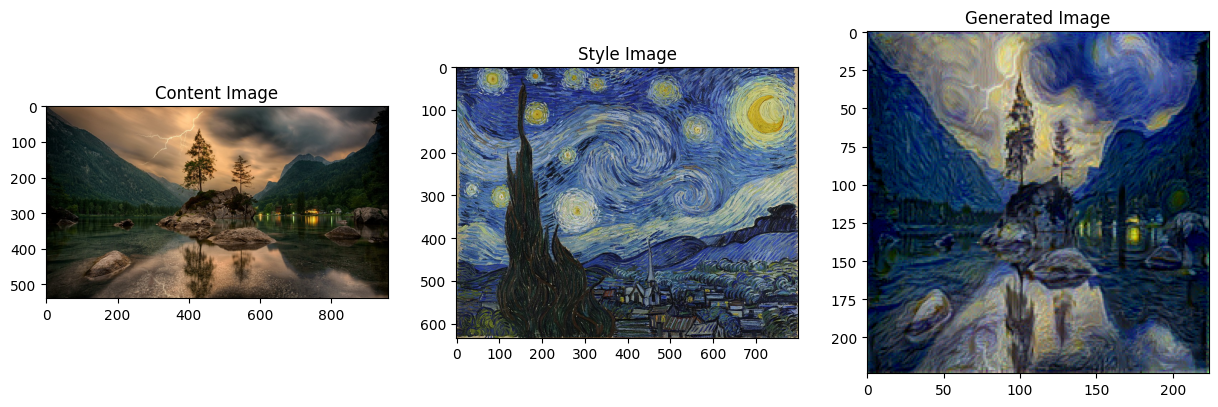

In [17]:
generateImage(style_image_path='style-images/style-3.jpg',content_image_path='content-images/content-4.jpg')

  5%|████                                                                              | 5/100 [00:00<00:05, 16.35it/s]

Epoch:0 | Train_loss:45.063140869140625 | Content_loss:0.0000 | Style_loss:0.0006


 15%|████████████▏                                                                    | 15/100 [00:01<00:07, 11.93it/s]

Epoch:10 | Train_loss:15.953173637390137 | Content_loss:0.0157 | Style_loss:0.0002


 25%|████████████████████▎                                                            | 25/100 [00:02<00:06, 11.91it/s]

Epoch:20 | Train_loss:5.137601375579834 | Content_loss:0.0175 | Style_loss:0.0001


 35%|████████████████████████████▎                                                    | 35/100 [00:03<00:05, 11.84it/s]

Epoch:30 | Train_loss:0.927091658115387 | Content_loss:0.0187 | Style_loss:0.0000


 45%|████████████████████████████████████▍                                            | 45/100 [00:04<00:04, 11.84it/s]

Epoch:40 | Train_loss:0.9456812143325806 | Content_loss:0.0204 | Style_loss:0.0000


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:05<00:03, 11.93it/s]

Epoch:50 | Train_loss:0.47509893774986267 | Content_loss:0.0209 | Style_loss:0.0000


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:06<00:02, 11.92it/s]

Epoch:60 | Train_loss:0.3177189230918884 | Content_loss:0.0205 | Style_loss:0.0000


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:07<00:02, 11.89it/s]

Epoch:70 | Train_loss:0.2706317901611328 | Content_loss:0.0201 | Style_loss:0.0000


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:08<00:01, 11.76it/s]

Epoch:80 | Train_loss:0.22393223643302917 | Content_loss:0.0199 | Style_loss:0.0000


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:08<00:00, 11.79it/s]

Epoch:90 | Train_loss:0.20476365089416504 | Content_loss:0.0193 | Style_loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.55it/s]


Generated image saved to generated-images\image_78500.png


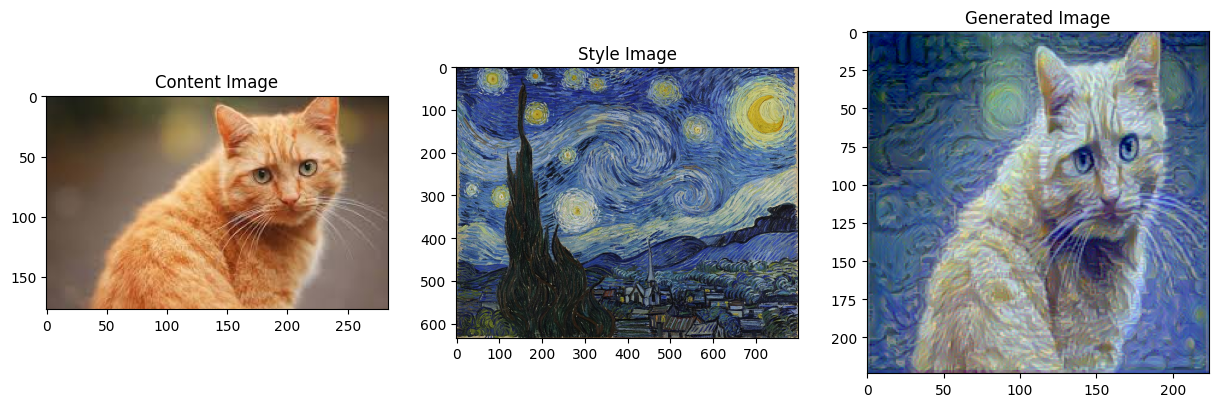

In [18]:
generateImage(style_image_path='style-images/style-3.jpg',content_image_path='content-images/content-2.jpeg')

  5%|████                                                                              | 5/100 [00:00<00:06, 15.47it/s]

Epoch:0 | Train_loss:64.52452850341797 | Content_loss:0.0000 | Style_loss:0.0008


 16%|████████████▉                                                                    | 16/100 [00:01<00:07, 11.84it/s]

Epoch:10 | Train_loss:23.153564453125 | Content_loss:0.0265 | Style_loss:0.0003


 22%|█████████████████▊                                                               | 22/100 [00:02<00:09,  8.50it/s]

Epoch:20 | Train_loss:16.118715286254883 | Content_loss:0.0253 | Style_loss:0.0002


 35%|████████████████████████████▎                                                    | 35/100 [00:03<00:05, 11.50it/s]

Epoch:30 | Train_loss:12.271052360534668 | Content_loss:0.0247 | Style_loss:0.0002


 45%|████████████████████████████████████▍                                            | 45/100 [00:04<00:04, 11.79it/s]

Epoch:40 | Train_loss:8.919022560119629 | Content_loss:0.0249 | Style_loss:0.0001


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:05<00:03, 11.93it/s]

Epoch:50 | Train_loss:5.958822250366211 | Content_loss:0.0253 | Style_loss:0.0001


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:06<00:02, 11.87it/s]

Epoch:60 | Train_loss:3.893414258956909 | Content_loss:0.0256 | Style_loss:0.0000


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:07<00:02, 11.79it/s]

Epoch:70 | Train_loss:2.7095677852630615 | Content_loss:0.0255 | Style_loss:0.0000


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:08<00:01, 11.81it/s]

Epoch:80 | Train_loss:2.091461181640625 | Content_loss:0.0255 | Style_loss:0.0000


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:09<00:00, 11.92it/s]

Epoch:90 | Train_loss:1.7391303777694702 | Content_loss:0.0254 | Style_loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.53it/s]


Generated image saved to generated-images\image_97983.png


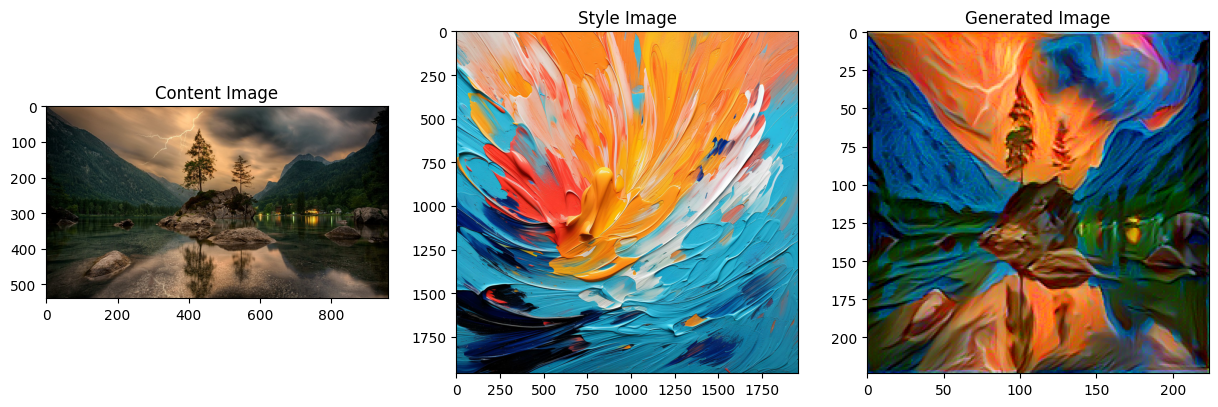

In [19]:
generateImage(style_image_path='style-images/style-5.jpg',content_image_path='content-images/content-4.jpg')

  5%|████                                                                              | 5/100 [00:00<00:07, 12.85it/s]

Epoch:0 | Train_loss:22.14203643798828 | Content_loss:0.0000 | Style_loss:0.0003


 12%|█████████▋                                                                       | 12/100 [00:01<00:10,  8.20it/s]

Epoch:10 | Train_loss:6.607223033905029 | Content_loss:0.0123 | Style_loss:0.0001


 25%|████████████████████▎                                                            | 25/100 [00:02<00:06, 11.54it/s]

Epoch:20 | Train_loss:0.9096772074699402 | Content_loss:0.0130 | Style_loss:0.0000


 35%|████████████████████████████▎                                                    | 35/100 [00:03<00:05, 11.71it/s]

Epoch:30 | Train_loss:0.7400079965591431 | Content_loss:0.0158 | Style_loss:0.0000


 45%|████████████████████████████████████▍                                            | 45/100 [00:04<00:04, 11.77it/s]

Epoch:40 | Train_loss:0.3057691752910614 | Content_loss:0.0163 | Style_loss:0.0000


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:05<00:03, 11.75it/s]

Epoch:50 | Train_loss:0.2145688831806183 | Content_loss:0.0158 | Style_loss:0.0000


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:06<00:02, 11.83it/s]

Epoch:60 | Train_loss:0.14365610480308533 | Content_loss:0.0151 | Style_loss:0.0000


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:07<00:02, 11.82it/s]

Epoch:70 | Train_loss:0.11646789312362671 | Content_loss:0.0148 | Style_loss:0.0000


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:08<00:01, 11.79it/s]

Epoch:80 | Train_loss:0.09697620570659637 | Content_loss:0.0144 | Style_loss:0.0000


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:09<00:00, 11.84it/s]

Epoch:90 | Train_loss:0.08631382882595062 | Content_loss:0.0140 | Style_loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.44it/s]


Generated image saved to generated-images\image_6481.png


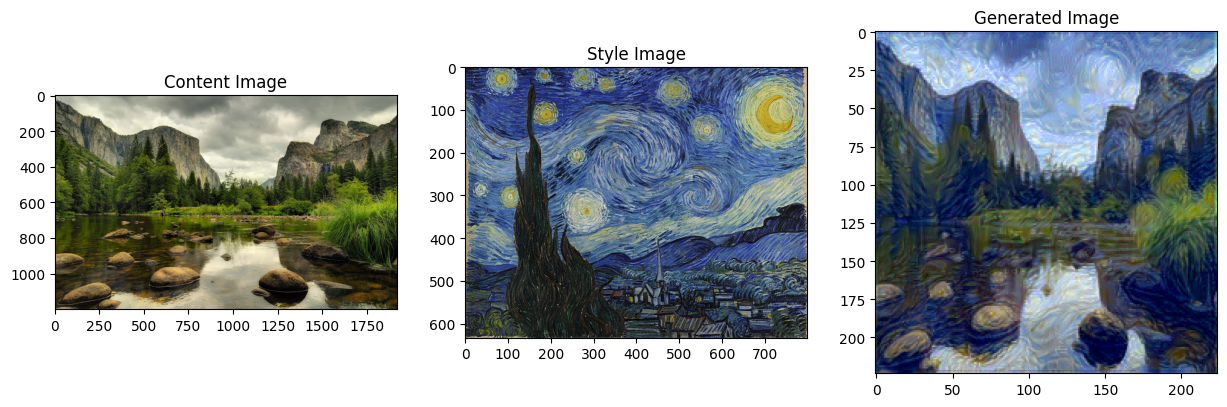

In [20]:
generateImage(style_image_path='style-images/style-3.jpg',content_image_path='content-images/content.jpg')

  5%|████                                                                              | 5/100 [00:00<00:07, 13.02it/s]

Epoch:0 | Train_loss:26.849992752075195 | Content_loss:0.0000 | Style_loss:0.0003


 16%|████████████▉                                                                    | 16/100 [00:01<00:05, 14.39it/s]

Epoch:10 | Train_loss:4.650897026062012 | Content_loss:0.0078 | Style_loss:0.0001


 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 14.68it/s]

Epoch:20 | Train_loss:1.772857427597046 | Content_loss:0.0136 | Style_loss:0.0000


 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 14.62it/s]

Epoch:30 | Train_loss:1.0345242023468018 | Content_loss:0.0156 | Style_loss:0.0000


 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:03, 14.61it/s]

Epoch:40 | Train_loss:0.6544020175933838 | Content_loss:0.0165 | Style_loss:0.0000


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:02, 14.74it/s]

Epoch:50 | Train_loss:0.4386531114578247 | Content_loss:0.0168 | Style_loss:0.0000


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 14.49it/s]

Epoch:60 | Train_loss:0.33249571919441223 | Content_loss:0.0167 | Style_loss:0.0000


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 14.62it/s]

Epoch:70 | Train_loss:0.2668555974960327 | Content_loss:0.0164 | Style_loss:0.0000


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:00, 14.67it/s]

Epoch:80 | Train_loss:0.2256094366312027 | Content_loss:0.0162 | Style_loss:0.0000


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 14.59it/s]

Epoch:90 | Train_loss:0.19700923562049866 | Content_loss:0.0160 | Style_loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.23it/s]


Generated image saved to generated-images\image_2598.png


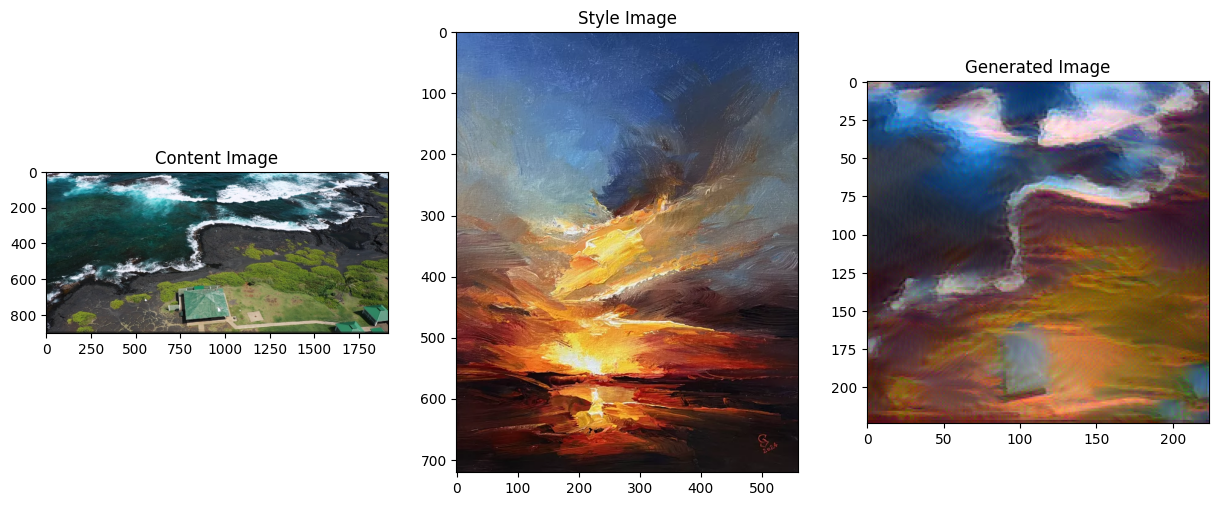

In [32]:
generateImage(style_image_path='style-images/style-8.jpg',content_image_path='content-images/content-8.jpg')

In [33]:
def styletransferForVideo(epochs:int, alpha:float, beta:float, style_image_path:str, model:torch.nn.Module, w:float,content_img,device):
    content_img=preprocess_frame(content_img).to(device)
    style_img=load_and_preprocess_image(style_image_path).to(device)
    target_img=content_img.clone().requires_grad_(True).to(device)
    optimizer=torch.optim.Adam(params=[target_img],lr=0.01)
   
    for epoch in range(epochs):
        model.eval()
        with torch.inference_mode():
            style_features=model(style_img)
            content_features=model(content_img)
    
        model.train()    
        target_features=model(target_img)
        style_loss,content_loss =0,0
        content_loss = 0.5 * torch.mean((target_features[-1] - content_features[-1])**2)

        for style_layer,target_layer in zip(style_features,target_features):
            _,channels,height,width=target_layer.shape
            style_gram=compute_gram_matrix(style_layer)
            target_gram=compute_gram_matrix(target_layer)
            style_loss += w* torch.mean((style_gram - target_gram)**2)/(4*((channels)**2)*(width*height))
        total_loss = alpha * content_loss + beta * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    target_img=target_img.cpu().detach().squeeze(dim=0).permute(1,2,0).numpy()
    target_img = np.clip(target_img, 0, 1) 
    return target_img

In [34]:
def preprocess_frame(img):
    img=img_transform(img)
    img=img.unsqueeze(dim=0).to(device)
    return img

In [35]:
def generateStyleVideo(content_video_path:str,style_image_path:str):
    
    cap = cv2.VideoCapture(content_video_path)
    frames=[]
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
        frames.append(frame_rgb)
    cap.release()
    print(f"Processing {len(frames)} frames !!!")
    generated_video_frames=[]
    batch_size = 5  
    for batch_start in range(0, len(frames), batch_size):
        batch_frames = frames[batch_start:batch_start + batch_size]
        batch_pil_frames = [Image.fromarray(frame) for frame in batch_frames]
        for frame_no, frame_pil in enumerate(batch_pil_frames):
            generated_frame = styletransferForVideo(epochs=100, alpha=0.8, beta=8000, w=0.2,
                                                    style_image_path=style_image_path, model=nstmodel,
                                                    content_img=frame_pil, device=device)
            generated_video_frames.append(generated_frame)
            temp_frames.append(generated_frame)
            if (frame_no + batch_start) % 50 == 0 and (frame_no + batch_start) != 0 :
                print(f"50 frames processed successfully!!!")

    video_no=np.random.randint(0,100000)
    output_folder = Path("generated-videos")
    output_folder.mkdir(exist_ok=True,parents=True)  
    output_video_path = output_folder / f"video_{video_no}.mp4"
    if create_video_from_frames("temp-trail", str(output_video_path)):
        print(f"Generated video saved to {output_video_path}")
        return True
    else:
        print("Failed to generate video.")
        return False
    
    
    
        

In [36]:
temp_frames=[]

In [ ]:
generateStyleVideo(content_video_path='content-videos/content-video-4.mp4',style_image_path='style-images/style-8.jpg')

In [39]:
len(temp_frames)

370

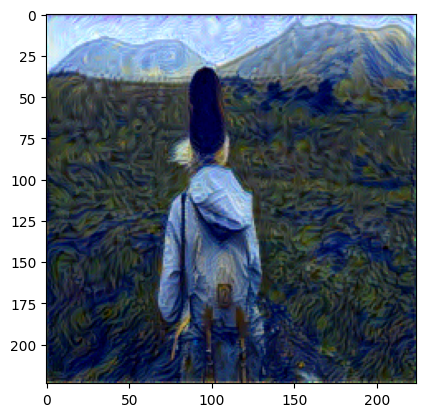

In [344]:
plt.imshow(temp_frames[120])

  5%|████                                                                              | 5/100 [00:00<00:07, 12.53it/s]

Epoch:0 | Train_loss:27.652406692504883 | Content_loss:0.0000 | Style_loss:0.0003


 16%|████████████▉                                                                    | 16/100 [00:01<00:05, 14.11it/s]

Epoch:10 | Train_loss:6.600100994110107 | Content_loss:0.0170 | Style_loss:0.0001


 26%|█████████████████████                                                            | 26/100 [00:02<00:05, 14.46it/s]

Epoch:20 | Train_loss:1.5868892669677734 | Content_loss:0.0176 | Style_loss:0.0000


 36%|█████████████████████████████▏                                                   | 36/100 [00:02<00:04, 14.73it/s]

Epoch:30 | Train_loss:0.7591378092765808 | Content_loss:0.0207 | Style_loss:0.0000


 46%|█████████████████████████████████████▎                                           | 46/100 [00:03<00:03, 14.71it/s]

Epoch:40 | Train_loss:0.5967616438865662 | Content_loss:0.0220 | Style_loss:0.0000


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:04<00:02, 14.75it/s]

Epoch:50 | Train_loss:0.3611766993999481 | Content_loss:0.0219 | Style_loss:0.0000


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:05<00:02, 14.64it/s]

Epoch:60 | Train_loss:0.3094470500946045 | Content_loss:0.0203 | Style_loss:0.0000


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:05<00:01, 14.63it/s]

Epoch:70 | Train_loss:0.24994398653507233 | Content_loss:0.0204 | Style_loss:0.0000


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:06<00:00, 14.58it/s]

Epoch:80 | Train_loss:0.21766749024391174 | Content_loss:0.0196 | Style_loss:0.0000


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:07<00:00, 14.68it/s]

Epoch:90 | Train_loss:0.1918032467365265 | Content_loss:0.0193 | Style_loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.24it/s]


Generated image saved to generated-images\image_99280.png


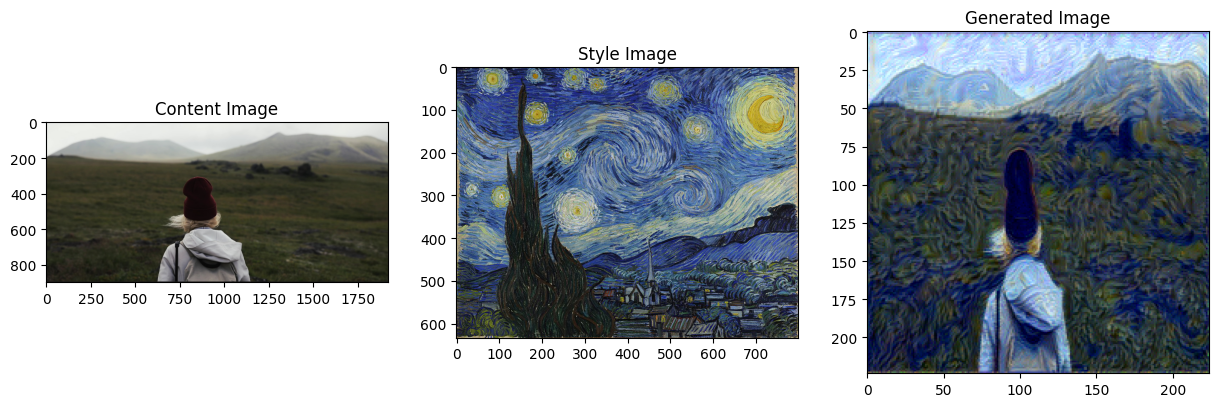

In [328]:
generateImage(style_image_path='style-images/style-3.jpg',content_image_path='content-images/content-5.jpg')

In [113]:
temp_frames=[]

In [114]:
generateStyleVideo(content_video_path='content-videos/content-video.mp4',style_image_path='style-images/style-7.jpg')

Processing 270 frames !!!
50 frames processed successfully!!!
50 frames processed successfully!!!
50 frames processed successfully!!!
50 frames processed successfully!!!
50 frames processed successfully!!!
50 frames processed successfully!!!
Generated video saved to generated-videos\video_90144.mp4


In [23]:
def save_frames_to_folder(frames, folder_path="temp-trail"):
    os.makedirs(folder_path, exist_ok=True)
    for frame_no, frame in enumerate(frames):
        frame_scaled = (frame * 255).astype(np.uint8)
        frame_bgr = cv2.cvtColor(frame_scaled, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(folder_path, f"frame_{frame_no:04d}.jpg"), frame_bgr)
    print(f"All Frames saved successfully!!!")


In [40]:
import os
import cv2
import numpy as np


output_folder = "temp-trail"
os.makedirs(output_folder, exist_ok=True)


for idx, frame in enumerate(temp_frames):
    frame_scaled = (frame * 255).astype(np.uint8)

   
    frame_bgr = cv2.cvtColor(frame_scaled, cv2.COLOR_RGB2BGR)

    
    cv2.imwrite(os.path.join(output_folder, f"frame_{idx}.jpg"), frame_bgr)

print(f"Saved {len(temp_frames)} frames to {output_folder}.")


Saved 370 frames to temp-trail.


In [42]:
before_list=[]

In [43]:
dummy_list=[]

In [24]:
def create_video_from_frames(frames_folder, output_video_path, frame_rate=30, codec='XVID'):
    image_files = [os.path.join(frames_folder, f) for f in os.listdir(frames_folder) if f.endswith('.jpg')]
    sorted_image_files = sorted(image_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[1]))

    if not sorted_image_files:
        return False

    first_image = cv2.imread(sorted_image_files[0])
    height, width, _ = first_image.shape
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))

    for image_file in sorted_image_files:
        image = cv2.imread(image_file)
        out.write(image)

    out.release()

    
    if os.path.exists(frames_folder):
        for file in os.listdir(frames_folder):
            file_path = os.path.join(frames_folder, file)
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
        os.rmdir(frames_folder)

    return True
